# Imports

In [1]:
#!pip install pyspark onnxmltools boto3 pd matplotlib

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
import pyspark.sql.functions as F
from pyspark.sql.functions import sum, when, avg, max, col, dayofweek, count, month, lit, mean
from pyspark.sql.window import Window
from pyspark.ml.feature import StringIndexer, OneHotEncoder, Imputer
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.regression import RandomForestRegressor
from pyspark.sql.functions import expr
from pyspark.sql import Row
from pyspark.sql.types import DateType

from onnxmltools import convert_sparkml
from onnxmltools.convert.sparkml.utils import buildInitialTypesSimple

import boto3
from botocore.exceptions import NoCredentialsError

import pandas as pd
from io import StringIO

In [3]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
spark = SparkSession.builder.appName('RHODS').getOrCreate()

In [5]:
spark.catalog.clearCache()
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", 1024 * 1024 * 1024)

# Data extraction

In [6]:
ionos_endpoint_url = 'https://sales-challenge.s3-eu-central-1.ionoscloud.com'
ionos_region = 'de'

ionos_access_key = '00d4804864744cc11eb4'
ionos_secret_key = 'peqgMLZSwt59HRwg+BgAMxeuwDkkIwkYcTVRSZWq'

s3 = boto3.client('s3',
    aws_access_key_id=ionos_access_key,
    aws_secret_access_key=ionos_secret_key,
    endpoint_url=ionos_endpoint_url,
    region_name=ionos_region
)


'''
SPARK
'''

spark = SparkSession.builder.appName('RHODS').getOrCreate()

spark.catalog.clearCache()
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", 1024 * 1024 * 1024)

'''
DATA EXTRACTION
'''

bucket_name_csv = 'csv'

file_names = ['train', 'oil', 'holidays_events','transactions']
Data = {}

for x in file_names:
    bucket_name = 'csv'
    object_key = x + '.csv'
    csv_obj = s3.get_object(Bucket=bucket_name, Key=object_key)
    body = csv_obj['Body']
    csv_string = body.read().decode('utf-8')
    df = spark.createDataFrame(pd.read_csv(StringIO(csv_string)))
    Data[x] = df

main_df = Data['train']
oil_df = Data['oil']
holidays_df = Data['holidays_events']
transactions_df = Data['transactions']

# Feature Engineering

In [7]:
main_df.show()

+---+----------+---------+-------------------+-----+-----------+
| id|      date|store_nbr|             family|sales|onpromotion|
+---+----------+---------+-------------------+-----+-----------+
|  0|2013-01-01|        1|         AUTOMOTIVE|  0.0|          0|
|  1|2013-01-01|        1|          BABY CARE|  0.0|          0|
|  2|2013-01-01|        1|             BEAUTY|  0.0|          0|
|  3|2013-01-01|        1|          BEVERAGES|  0.0|          0|
|  4|2013-01-01|        1|              BOOKS|  0.0|          0|
|  5|2013-01-01|        1|       BREAD/BAKERY|  0.0|          0|
|  6|2013-01-01|        1|        CELEBRATION|  0.0|          0|
|  7|2013-01-01|        1|           CLEANING|  0.0|          0|
|  8|2013-01-01|        1|              DAIRY|  0.0|          0|
|  9|2013-01-01|        1|               DELI|  0.0|          0|
| 10|2013-01-01|        1|               EGGS|  0.0|          0|
| 11|2013-01-01|        1|       FROZEN FOODS|  0.0|          0|
| 12|2013-01-01|        1

## Train_df Aggregation, Date transformation

In [8]:
# Aggregation of the main_df to get the sales volumes aggregatet over all stores for each product family and date
agg_df = main_df.groupBy('date', 'family').agg(sum('sales').alias("sales"), sum('onpromotion').alias("onpromotion"))

# Adding of features related to the day of the week and the month of each record based on the date
agg_df = agg_df.withColumn('day_of_week', dayofweek(agg_df.date)).withColumn('month', month(agg_df.date))
agg_df.sort(col("date"), col("family")).show(truncate = False)

+----------+-------------------+---------+-----------+-----------+-----+
|date      |family             |sales    |onpromotion|day_of_week|month|
+----------+-------------------+---------+-----------+-----------+-----+
|2013-01-01|AUTOMOTIVE         |0.0      |0          |3          |1    |
|2013-01-01|BABY CARE          |0.0      |0          |3          |1    |
|2013-01-01|BEAUTY             |2.0      |0          |3          |1    |
|2013-01-01|BEVERAGES          |810.0    |0          |3          |1    |
|2013-01-01|BOOKS              |0.0      |0          |3          |1    |
|2013-01-01|BREAD/BAKERY       |180.589  |0          |3          |1    |
|2013-01-01|CELEBRATION        |0.0      |0          |3          |1    |
|2013-01-01|CLEANING           |186.0    |0          |3          |1    |
|2013-01-01|DAIRY              |143.0    |0          |3          |1    |
|2013-01-01|DELI               |71.09    |0          |3          |1    |
|2013-01-01|EGGS               |46.0     |0        

# Visuals

In [9]:
# converting pyspark Df to pandas
agg_df_pandas = agg_df.toPandas()

In [10]:
# function for plotting

def plotting_1(df, grouper, target, plot_title):
       import pandas as pd
       import matplotlib.pyplot as plt
       grouper_target = pd.DataFrame(df.groupby(grouper)[target].mean()).reset_index()
       # plotting the head and tail from the data frame including mean prices of car manufacturers
       df_plt = pd.concat([grouper_target.sort_values(target, ascending=False).head(), grouper_target.sort_values(target, ascending=False).tail()])

       fig = plt.figure(figsize=(15, 8))
       ax = fig.add_axes([0,0,1,1])
       langs = df_plt[grouper]
       plot_obj = df_plt[target]
       ax.bar(langs,plot_obj, width = 0.9)
       ax.set(xlabel=grouper,
              ylabel=('average {}'.format(target)))
       ax.set_title(plot_title, fontsize=20)
       plt.show()

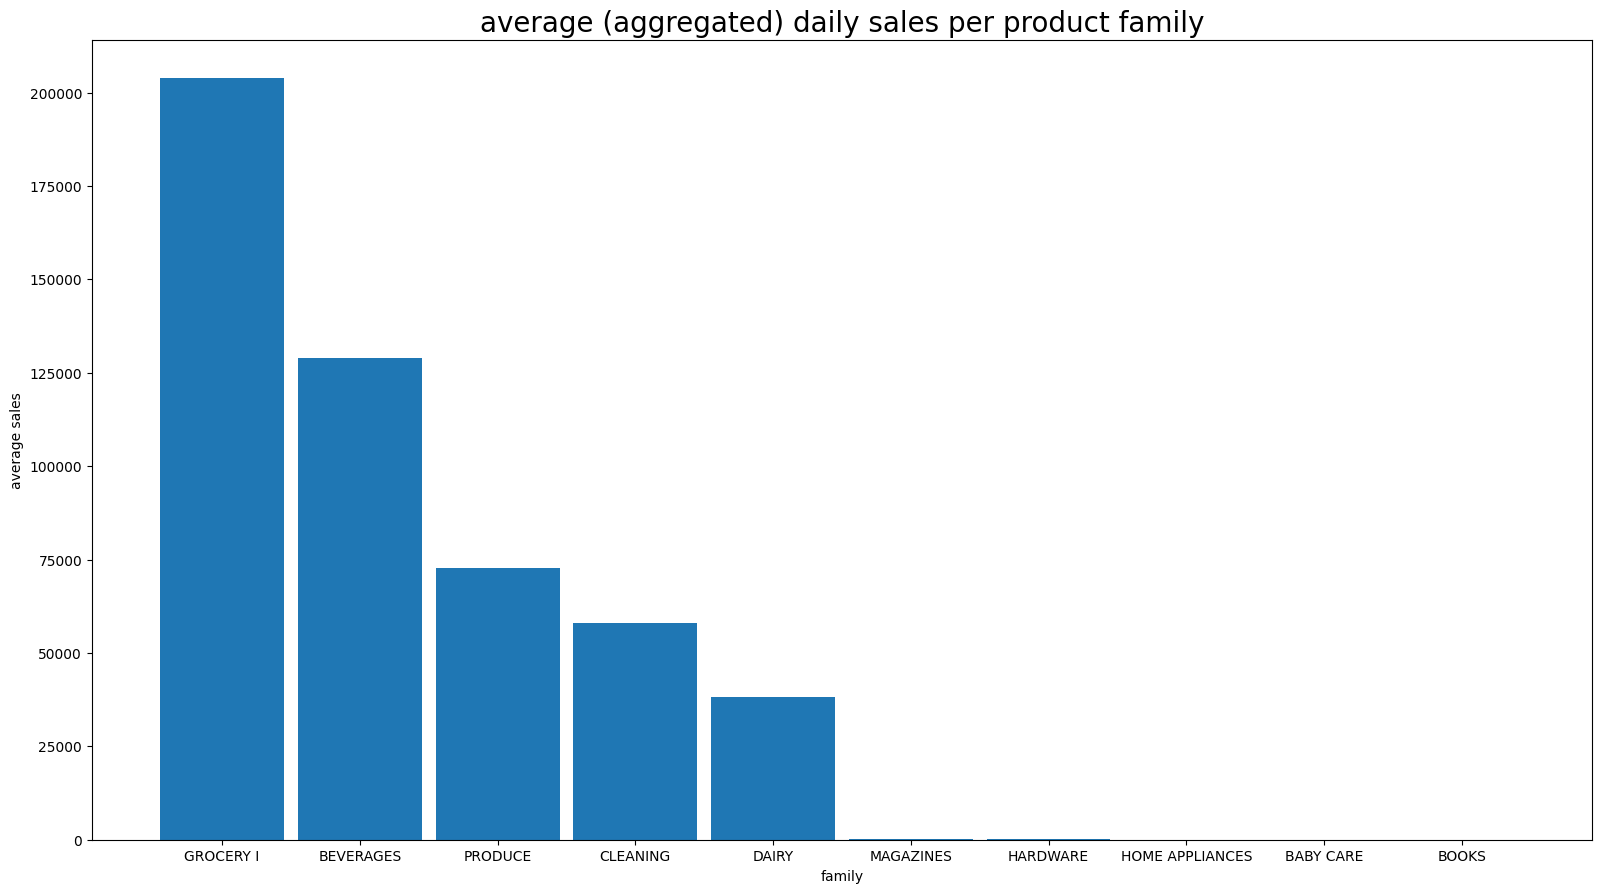

In [11]:
plotting_1(df = agg_df_pandas,
           grouper = "family",
           target = "sales",
           plot_title='average (aggregated) daily sales per product family')

## Oil_df Merge
In this section the agg_df and the oil_df are getting merged to use the oil price in the ML-Part of the project

### Preprocessing

In [12]:
# Aggregating the oil_df and the agg_df
agg_oil_merge_df = agg_df.join(oil_df, on='date', how='left') # left join agg_df and oil_df
agg_oil_merge_df = agg_oil_merge_df.dropDuplicates(['date']) # reduce df to one row per date

# Calculate the percentage of NaN values in the 'dcoilwtico' column
percentage_nan = (agg_oil_merge_df.filter(col("dcoilwtico").isNull()).count() / agg_oil_merge_df.count()) * 100
print(f'Procentual number of NaN-Values: {percentage_nan}%')

Procentual number of NaN-Values: 28.56294536817102%


Because of the high number of NaN-Values regarding the oilprice-value we decided to do a oilprice forecast

[]

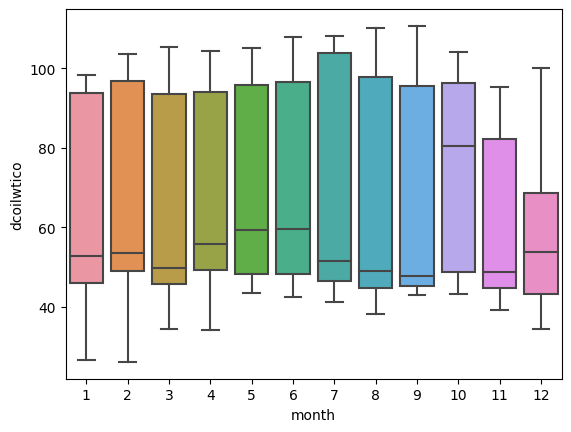

In [13]:
# plotting boxplots month against oil price
import seaborn as sns
import pandas as pd

sns.boxplot(x = "month", y = "dcoilwtico", data = agg_oil_merge_df.toPandas()).set()

### Oilprice forecast

In [14]:
# Create a subset of agg_oil_merge_df to forecast the oil prices
oil_forecast_df = agg_oil_merge_df.select('date', 'dcoilwtico', 'day_of_week', 'month')

In [15]:
n_lags = 5
window_spec = Window.orderBy('date')
for i in range(1, n_lags+1):
  oil_forecast_df = oil_forecast_df.withColumn("lag_{}".format(i), F.lag("dcoilwtico", offset = i).over(window_spec).cast('float'))

oil_forecast_df = oil_forecast_df.withColumn("dcoilwtico", oil_forecast_df["dcoilwtico"].cast('float'))
oil_forecast_df.show()

+----------+----------+-----------+-----+-----+-----+-----+-----+-----+
|      date|dcoilwtico|day_of_week|month|lag_1|lag_2|lag_3|lag_4|lag_5|
+----------+----------+-----------+-----+-----+-----+-----+-----+-----+
|2013-01-01|       NaN|          3|    1| NULL| NULL| NULL| NULL| NULL|
|2013-01-02|     93.14|          4|    1|  NaN| NULL| NULL| NULL| NULL|
|2013-01-03|     92.97|          5|    1|93.14|  NaN| NULL| NULL| NULL|
|2013-01-04|     93.12|          6|    1|92.97|93.14|  NaN| NULL| NULL|
|2013-01-05|      NULL|          7|    1|93.12|92.97|93.14|  NaN| NULL|
|2013-01-06|      NULL|          1|    1| NULL|93.12|92.97|93.14|  NaN|
|2013-01-07|      93.2|          2|    1| NULL| NULL|93.12|92.97|93.14|
|2013-01-08|     93.21|          3|    1| 93.2| NULL| NULL|93.12|92.97|
|2013-01-09|     93.08|          4|    1|93.21| 93.2| NULL| NULL|93.12|
|2013-01-10|     93.81|          5|    1|93.08|93.21| 93.2| NULL| NULL|
|2013-01-11|      93.6|          6|    1|93.81|93.08|93.21| 93.2

#### Data transformation/encoding/split, Pipeline creation

In [16]:
numerical_cols_oil = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']
categorical_cols_oil = ['day_of_week', 'month']

# Defining the encoder for encoding the categorical values
encoder_oil = OneHotEncoder(inputCols=categorical_cols_oil,
                        outputCols=[f"{col}_encoded" for col in categorical_cols_oil])

oil_forecast_encoded_df = encoder_oil.fit(oil_forecast_df).transform(oil_forecast_df)

In [17]:
# Create the train set of data with oil prices
oil_fc_train = oil_forecast_encoded_df.na.drop(subset=["dcoilwtico"])
# Create the prediction set of data without oil prices
oil_fc_pred = oil_forecast_encoded_df.filter(oil_forecast_encoded_df['dcoilwtico'].isNull())

In [18]:
# Set the imputer
numerical_imputer_oil = Imputer(strategy="median", inputCols=numerical_cols_oil, outputCols=[f"{col}_imputed" for col in numerical_cols_oil])

# Assemble features into a single vector
feature_cols_oil = [f"{col}_imputed" for col in numerical_cols_oil] + [f"{col}_encoded" for col in categorical_cols_oil]
assembler_oil = VectorAssembler(inputCols=feature_cols_oil, outputCol="features")

# Initialise the oilprice prediction model
rfr_oil = RandomForestRegressor(featuresCol='features', labelCol='dcoilwtico')

# Create the data preprocessing pipeline
pipeline_oil = Pipeline(stages=[numerical_imputer_oil, assembler_oil, rfr_oil]) # pipeline for cross validation

#### Model training

In [19]:
paramGrid_oil = ParamGridBuilder() \
    .addGrid(rfr_oil.maxDepth, [5,7]) \
    .addGrid(rfr_oil.numTrees, [10, 20, 30]) \
    .addGrid(rfr_oil.maxDepth, [5, 10, 15]) \
    .build()

evaluator = RegressionEvaluator(labelCol="dcoilwtico", predictionCol="prediction", metricName="mae")

crossval = CrossValidator(estimator=pipeline_oil,
                          estimatorParamMaps=paramGrid_oil,
                          evaluator=evaluator,
                          numFolds=5)

cv_model_oil = crossval.fit(oil_fc_train)

best_model_oil = cv_model_oil.bestModel # Model with the best parameters

oil_predictions = best_model_oil.transform(oil_fc_pred)

#### Oil price dataframe creation

In [20]:
oil_new_df = oil_fc_train.select('date', 'dcoilwtico').union(oil_predictions.select('date', 'prediction').withColumnRenamed("prediction",'dcoilwtico'))
oil_new_df.sort(col("date")).show(truncate = False)

+----------+-----------------+
|date      |dcoilwtico       |
+----------+-----------------+
|2013-01-02|93.13999938964844|
|2013-01-03|92.97000122070312|
|2013-01-04|93.12000274658203|
|2013-01-05|93.37983235253229|
|2013-01-06|92.30633353763157|
|2013-01-07|93.19999694824219|
|2013-01-08|93.20999908447266|
|2013-01-09|93.08000183105469|
|2013-01-10|93.80999755859375|
|2013-01-11|93.5999984741211 |
|2013-01-12|94.35044201472448|
|2013-01-13|92.3127214855618 |
|2013-01-14|94.2699966430664 |
|2013-01-15|93.26000213623047|
|2013-01-16|94.27999877929688|
|2013-01-17|95.48999786376953|
|2013-01-18|95.61000061035156|
|2013-01-19|95.88346097431486|
|2013-01-20|93.67865513695612|
|2013-01-22|96.08999633789062|
+----------+-----------------+
only showing top 20 rows



In [21]:
# Now the new_oil_df gets merged with the agg_df to do further preprocessing
agg_oilprice_merged_df = agg_df.join(oil_new_df, on='date', how='left')

# There are no NaN-Values left in the Column "dcoilwtico"
percentage_nan = (agg_oilprice_merged_df.filter(col("dcoilwtico").isNull()).count() / agg_oilprice_merged_df.count()) * 100
print(f'Procentual number of NaN-Values: {percentage_nan}%')

Procentual number of NaN-Values: 2.375296912114014%


## Transactions_df Merge
In this section we merge the aggregations_df with the agg_df to use the number of transaction per day for furter predictions

In [22]:
agg_transactions_df = transactions_df.groupBy("date").agg(sum("transactions").alias("transactions"))
agg_transactions_df.sort(col("date")).show(truncate = False)

+----------+------------+
|date      |transactions|
+----------+------------+
|2013-01-01|770         |
|2013-01-02|93215       |
|2013-01-03|78504       |
|2013-01-04|78494       |
|2013-01-05|93573       |
|2013-01-06|90464       |
|2013-01-07|75597       |
|2013-01-08|72325       |
|2013-01-09|71971       |
|2013-01-10|66383       |
|2013-01-11|70338       |
|2013-01-12|85511       |
|2013-01-13|86306       |
|2013-01-14|70078       |
|2013-01-15|71134       |
|2013-01-16|72471       |
|2013-01-17|68873       |
|2013-01-18|71371       |
|2013-01-19|88558       |
|2013-01-20|85281       |
+----------+------------+
only showing top 20 rows



In [23]:
merged_df = agg_oilprice_merged_df.join(agg_transactions_df, on='date', how='left')
merged_df = merged_df.na.drop()
merged_df.sort(col("date"), col("family")).show(truncate = False)

+----------+-------------------+------------------+-----------+-----------+-----+-----------------+------------+
|date      |family             |sales             |onpromotion|day_of_week|month|dcoilwtico       |transactions|
+----------+-------------------+------------------+-----------+-----------+-----+-----------------+------------+
|2013-01-02|AUTOMOTIVE         |255.0             |0          |4          |1    |93.13999938964844|93215       |
|2013-01-02|BABY CARE          |0.0               |0          |4          |1    |93.13999938964844|93215       |
|2013-01-02|BEAUTY             |207.0             |0          |4          |1    |93.13999938964844|93215       |
|2013-01-02|BEVERAGES          |72092.0           |0          |4          |1    |93.13999938964844|93215       |
|2013-01-02|BOOKS              |0.0               |0          |4          |1    |93.13999938964844|93215       |
|2013-01-02|BREAD/BAKERY       |26246.319         |0          |4          |1    |93.139999389648

### Holidays_df Merge
In this section the holidays_df gets merged to use the transaction data for the upcoming model prediction

In [24]:
# We only want to use the Holiday/Additional,etc. data which counts for the whole country Ecuador
modified_holidays_df = holidays_df.filter((col("transferred") == False) & (col("locale") == "National"))
modified_holidays_df = modified_holidays_df.withColumn("type", when(col("type") == "Transfer", "Holiday").otherwise(col("type")))

modified_holidays_df = modified_holidays_df.select("date", "type")
modified_holidays_df.sort(col("date")).show(truncate = False)

+----------+----------+
|date      |type      |
+----------+----------+
|2012-08-10|Holiday   |
|2012-10-12|Holiday   |
|2012-11-02|Holiday   |
|2012-11-03|Holiday   |
|2012-12-21|Additional|
|2012-12-22|Additional|
|2012-12-23|Additional|
|2012-12-24|Bridge    |
|2012-12-24|Additional|
|2012-12-25|Holiday   |
|2012-12-26|Additional|
|2012-12-31|Bridge    |
|2012-12-31|Additional|
|2013-01-01|Holiday   |
|2013-01-05|Work Day  |
|2013-01-12|Work Day  |
|2013-02-11|Holiday   |
|2013-02-12|Holiday   |
|2013-04-29|Holiday   |
|2013-05-01|Holiday   |
+----------+----------+
only showing top 20 rows



In [25]:
# Doing the merge of modified_holidays_df and merged_df
merged_df = merged_df.join(modified_holidays_df, on="date", how="left")
# The dates on which no holiday or something else encounted in the holiday_df takes place we insert "Normal" as a value
merged_df = merged_df.withColumn("type", when(merged_df["type"].isNull(), "Normal").otherwise(merged_df["type"]))

# Feature based prediction (fb)
In the first trained model for predicting the sales volumes we use a normal feature based prediction without taking into account previous values.

## Data transformation/encoding

In [26]:
# ## Data transformation/encoding
transformed_df_fb = merged_df

transformed_df_fb = transformed_df_fb.drop("date")

transformed_df_fb = transformed_df_fb.withColumnRenamed("day_of_week", "day_of_week_index")
transformed_df_fb = transformed_df_fb.withColumnRenamed("month", "month_index")

str_cat_cols_fb = ["type", "family"]
cat_cols_fb = ["day_of_week", "month", "type", "family"]

indexers_fb = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in str_cat_cols_fb]
encoders_fb = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_encoded") for col in cat_cols_fb]

for encoder in encoders_fb:
    encoder.setHandleInvalid("keep")
    encoder.setDropLast(True)

feature_cols_fb = ["day_of_week_encoded", "month_encoded", "type_encoded", "family_encoded", "transactions", "dcoilwtico", "onpromotion"]


## Model training

In [27]:
##### MODEL TRAINING #####

assembler_fb = VectorAssembler(inputCols=feature_cols_fb, outputCol="features")

gbt_fb = GBTRegressor(featuresCol="features", labelCol="sales", maxBins=33)

pipeline_fb = Pipeline(stages= indexers_fb + encoders_fb + [assembler_fb, gbt_fb])

# Hyperparameter Tuning
paramGrid_fb = (ParamGridBuilder()
             .addGrid(gbt_fb.maxDepth, [4, 6])
             .addGrid(gbt_fb.maxIter, [50, 100])
             .addGrid(gbt_fb.stepSize, [0.1, 0.01])
             .build())

evaluator_fb = RegressionEvaluator(labelCol="sales", predictionCol="prediction", metricName="mae")

crossval_fb = CrossValidator(estimator=pipeline_fb,
                          estimatorParamMaps=paramGrid_fb,
                          evaluator=evaluator_fb,
                          numFolds=2)

train_data_fb, test_data_fb = transformed_df_fb.randomSplit([0.8, 0.2], seed=12)
cvModel_fb = crossval_fb.fit(train_data_fb)

## Evaluation

### Overall evaluation

In [28]:
# overall evaluation
evaluation_fb_df = cvModel_fb.transform(test_data_fb)
clipped_evaluation_fb_df = evaluation_fb_df.withColumn("clipped_predictions", when(col("prediction") < 0, 0).otherwise(col("prediction")))
evaluator_clipped_fb = RegressionEvaluator(labelCol="sales", predictionCol="clipped_predictions", metricName="mae")
mae_fb = evaluator_clipped_fb.evaluate(clipped_evaluation_fb_df)


best_model_fb = cvModel_fb.bestModel

print("Mean Absolute Error (MAE):", mae_fb)

Mean Absolute Error (MAE): 1878.2694258673382


In [29]:
# Show the true sales values compared to the predicted ones
clipped_evaluation_fb_df.select("sales", "clipped_predictions").show()

+-----+-------------------+
|sales|clipped_predictions|
+-----+-------------------+
|136.0| 132.63443316900987|
|155.0|                0.0|
|164.0|                0.0|
|166.0|                0.0|
|167.0| 120.07551591130472|
|167.0|   80.0162378927207|
|170.0|  66.91354340065915|
|172.0| 280.45833035470315|
|174.0|  3.268522147556502|
|175.0|  54.91654591219058|
|177.0|  301.3266840290356|
|178.0|  210.0010044625727|
|181.0|                0.0|
|182.0|                0.0|
|185.0|  383.8370372306253|
|188.0| 192.82043657922222|
|188.0|  412.3139010905319|
|189.0|  138.4609695303892|
|189.0|   37.9770563866124|
|190.0|  76.62022847267453|
+-----+-------------------+
only showing top 20 rows



### Product family wise evaluation

In [30]:
filtered_evaluation_fb_df = clipped_evaluation_fb_df.select("family", "sales", "clipped_predictions")
evaluator = RegressionEvaluator(labelCol="sales", predictionCol="clipped_predictions", metricName="mae")
unique_family_values = filtered_evaluation_fb_df.select("family").distinct().rdd.flatMap(lambda x: x).collect()

data = []
for value in unique_family_values:
  df_fb = filtered_evaluation_fb_df.filter(filtered_evaluation_fb_df['family'] == value)
  mae_fb = evaluator.evaluate(df_fb)
  mean_fb = df_fb.select(mean("sales")).collect()[0][0]
  row = Row(family=value, mean=mean_fb, mean_absolute_error=mae_fb)
  data.append(row)

family_evaluation_fb_df = spark.createDataFrame(data)

In [31]:
family_evaluation_fb_df.show()

+-------------------+------------------+-------------------+
|             family|              mean|mean_absolute_error|
+-------------------+------------------+-------------------+
|     PREPARED FOODS| 5305.299080971593| 448.03762080902993|
|HOME AND KITCHEN II| 985.9378531073446|  584.3474419784295|
|         LADIESWEAR|385.07758620689657| 304.36435137113153|
|    LAWN AND GARDEN|288.42105263157896|  358.1139971836576|
|          GROCERY I|198342.07661651913|  14673.93391191357|
|          BABY CARE| 4.852664576802508| 188.42527186517964|
|            PRODUCE| 68751.02064937791|  7772.533240341836|
|         AUTOMOTIVE| 336.1339031339031|  308.3961936192311|
|          BEVERAGES| 131452.5636942675| 12730.481728018674|
|          HOME CARE| 9498.302114803626| 1360.7147760360695|
|       BREAD/BAKERY|25291.034821351797|  1150.235703997689|
|              BOOKS|3.9345238095238093|  230.4859713234677|
|           LINGERIE| 398.8403614457831|  395.0989822247725|
|        CELEBRATION|407

In [32]:
pd_df_fameval_fb = family_evaluation_fb_df.toPandas()
pd_df_fameval_fb.to_csv('pd_df_fameval_fb.csv')

# Feature based prediction with Time lags (tl)

## Preprocessing

In [33]:
tl_df = merged_df # creating plain df for time-lagged data frame

window_spec = Window.partitionBy("family").orderBy("date")

# adding lags
tl_df = tl_df.withColumn("lag_1", F.lag("sales", 1).over(window_spec))
tl_df = tl_df.withColumn("lag_2", F.lag("sales", 2).over(window_spec))
tl_df = tl_df.withColumn("lag_3", F.lag("sales", 3).over(window_spec))

In [34]:
specific_date = "2013-01-05" # The Time lag dataframe should start from the "2013-01-04" because else there is no lag data for the first row
specific_date = spark.createDataFrame([(specific_date,)], ["specific_date"]).withColumn("specific_date", col("specific_date").cast(DateType()))
tl_df_filtered = tl_df.filter(col("date") >= specific_date.select("specific_date").collect()[0][0])

## Data transformation/encoding

In [35]:
# Data transformation/encoding

transformed_df_tl = tl_df_filtered

transformed_df_tl = transformed_df_tl.withColumnRenamed("day_of_week", "day_of_week_index")
transformed_df_tl = transformed_df_tl.withColumnRenamed("month", "month_index")

str_cat_cols_tl = ["type", "family"]
cat_cols_tl = ["day_of_week", "month", "type", "family"]

indexers_tl = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in str_cat_cols_tl]
encoders_tl = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_encoded") for col in cat_cols_tl]

for encoder in encoders_tl:
    encoder.setHandleInvalid("keep")
    encoder.setDropLast(True)

## Model training

In [36]:
##### MODEL TRAINING #####

feature_cols_tl = ["day_of_week_encoded", "month_encoded", "type_encoded", "family_encoded", "transactions", "dcoilwtico", "onpromotion", "lag_1", "lag_2", "lag_3"]

assembler_tl = VectorAssembler(inputCols=feature_cols_tl, outputCol="features")

gbt_tl = GBTRegressor(featuresCol="features", labelCol="sales", maxBins=33)

pipeline_tl = Pipeline(stages= indexers_tl + encoders_tl + [assembler_tl, gbt_tl])

paramGrid_tl = (ParamGridBuilder()
             .addGrid(gbt_tl.maxDepth, [4, 6])
             .addGrid(gbt_tl.maxIter, [50, 100])
             .addGrid(gbt_tl.stepSize, [0.1, 0.01])
             .build())

evaluator_tl = RegressionEvaluator(labelCol="sales", predictionCol="prediction", metricName="mae")

crossval_tl = CrossValidator(estimator=pipeline_tl,
                          estimatorParamMaps=paramGrid_tl,
                          evaluator=evaluator_tl,
                          numFolds=2)

train_data_tl, test_data_tl = transformed_df_tl.randomSplit([0.8, 0.2], seed=12)
cvModel_tl = crossval_tl.fit(train_data_tl)


In [37]:
train_data_tl.show()

+----------+-------------------+------------------+-----------+-----------------+-----------+-----------------+------------+--------+------------------+------------------+------------------+
|      date|             family|             sales|onpromotion|day_of_week_index|month_index|       dcoilwtico|transactions|    type|             lag_1|             lag_2|             lag_3|
+----------+-------------------+------------------+-----------+-----------------+-----------+-----------------+------------+--------+------------------+------------------+------------------+
|2013-01-05|         AUTOMOTIVE|             342.0|          0|                7|          1|93.37983235253229|       93573|Work Day|             169.0|             161.0|             255.0|
|2013-01-05|             BEAUTY|             191.0|          0|                7|          1|93.37983235253229|       93573|Work Day|             133.0|             125.0|             207.0|
|2013-01-05|          BEVERAGES|           77

## Evaluation

### Overall evaluation

In [38]:
evaluation_tl_df = cvModel_tl.transform(test_data_tl)
clipped_evaluation_tl_df = evaluation_tl_df.withColumn("clipped_predictions", when(col("prediction") < 0, 0).otherwise(col("prediction")))

evaluator_clipped_tl = RegressionEvaluator(labelCol="sales", predictionCol="clipped_predictions", metricName="mae")
mae_tl = evaluator_clipped_tl.evaluate(clipped_evaluation_tl_df)

best_model_tl = cvModel_tl.bestModel

print("Mean Absolute Error (MAE):", mae_tl)

Mean Absolute Error (MAE): 1435.3290092968232


In [39]:
# Show the true sales values compared to the predicted ones
clipped_evaluation_tl_df.select("sales", "clipped_predictions").show()

+------------------+-------------------+
|             sales|clipped_predictions|
+------------------+-------------------+
|               0.0| 116.66408099021946|
|           70128.0|  71241.07153275478|
|               0.0| 116.66408099021946|
|20879.091050000003|  21907.60119169124|
|               0.0| 116.66408099021946|
|               0.0| 116.66408099021946|
|             360.0| 272.28081040650403|
|               0.0|  72.56770213419621|
|          16229.26|  17417.12021489805|
|            1306.0|  1137.560501739694|
|               0.0|  72.56770213419621|
|           19665.0| 19735.573360230985|
|6233.7149899999995|  5725.178035495597|
|       1443.776992|  1137.560501739694|
|         17646.151|  17596.32805509772|
| 3823.622000000001|  4485.798112434384|
|              55.0|                0.0|
|               0.0|                0.0|
|              12.0|                0.0|
|               0.0|                0.0|
+------------------+-------------------+
only showing top

### Product family wise evaluation

In [40]:
filtered_evaluation_tl_df = clipped_evaluation_tl_df.select("family", "sales", "clipped_predictions")
evaluator = RegressionEvaluator(labelCol="sales", predictionCol="clipped_predictions", metricName="mae")
unique_family_values = filtered_evaluation_tl_df.select("family").distinct().rdd.flatMap(lambda x: x).collect()

data = []
for value in unique_family_values:
  df_tl = filtered_evaluation_tl_df.filter(filtered_evaluation_tl_df['family'] == value)
  mae_tl = evaluator.evaluate(df_tl)
  mean_tl = df_tl.select(mean("sales")).collect()[0][0]
  row = Row(family=value, mean=mean_tl, mean_absolute_error=mae_tl)
  data.append(row)

family_evaluation_tl_df = spark.createDataFrame(data)

In [ ]:
family_evaluation_tl_df.show()

In [41]:
pd_df_fameval_tl = family_evaluation_tl_df.toPandas()
pd_df_fameval_tl.to_csv('pd_df_fameval_tl.csv')

# Time Series Prediction (LSTM)

In [1]:
#!pip install keras tensorflow

In [43]:
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

In [44]:
'''
LSTM MODEL
'''
agg_df_pd = agg_df.toPandas()

grouped = agg_df_pd.groupby('family')
family_dataframes = {name: group for name, group in grouped}

automotive_df = family_dataframes['AUTOMOTIVE']
modified_automotive_df = automotive_df[['date', 'sales']]

window_size = 10

X, y = [], []
for i in range(len(modified_automotive_df) - window_size):
    try:
        X.append(modified_automotive_df['sales'].iloc[i:i+window_size].values)
        y.append(modified_automotive_df['sales'].iloc[i+window_size])
    except:
        if len(X) != len(y):
            X.pop()
        break
X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = keras.Sequential()
model.add(keras.layers.LSTM(50, activation='relu', input_shape=(window_size, 1)))
model.add(keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mean_absolute_error')

model.fit(X_train, y_train, epochs=1, batch_size=16)

# Model upload to the S3 bucket:

# model saving
# tf.saved_model.save(model,'model')
# ov_model = ov.convert_model('./model')

# ov.save_model(ov_model, 'model.xml')

# bucket_name_model = 'models'
# object_key_model_xml = 'lstm_model.xml'
# object_key_model_bin = 'lstm_model.bin'

# try:
#     s3.upload_file('./model.xml', bucket_name_model, object_key_model_xml)
#     s3.upload_file('./model.bin', bucket_name_model, object_key_model_bin)
#     print(f"LSTM model uploaded to S3 bucket {bucket_name_model} with key {object_key_model_xml}")
# except NoCredentialsError:
#     print("AWS credentials not available.")

84/84 [==============================] - 7s 38ms/step - loss: 269.6297


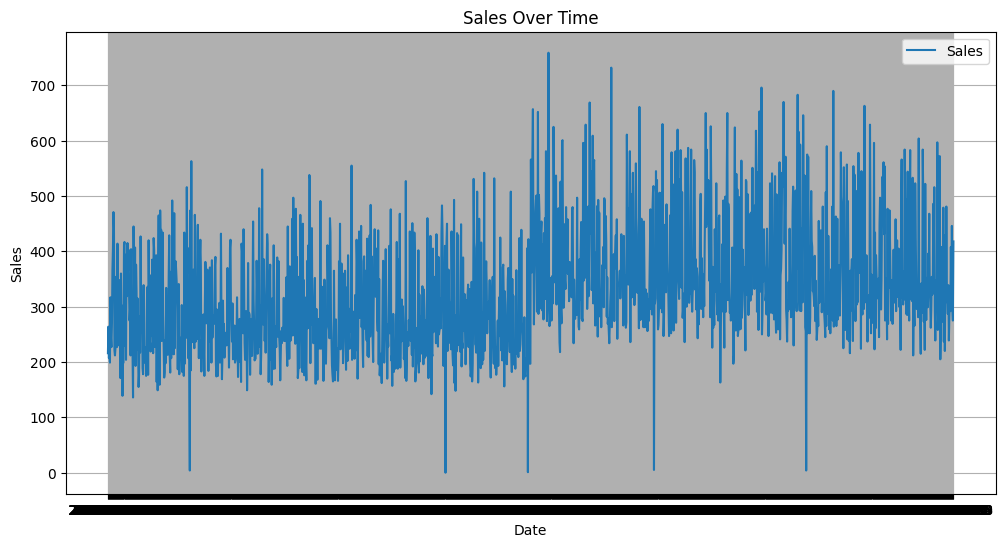

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(modified_automotive_df['date'], modified_automotive_df['sales'], label='Sales')
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.legend()
plt.show()

In [48]:
# LSTM evaluation
from tensorflow.keras.metrics import mean_absolute_error

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
evaluation_ts_df = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred.flatten()})
print(f'Mean Absolute Error: {mae}')
evaluation_ts_df.to_csv('LSTM_evaluation')

11/11 [==============================] - 0s 5ms/step
Mean Absolute Error: [246.07152  295.8669   107.998405  91.044876  79.82737   83.68563
 142.22012   90.19997   96.1898    90.393555  81.61181  125.10311
  96.48659   87.307274 150.49463  112.97555  125.84413  395.20868
 119.33925   98.28337  154.92976  196.95705  247.4481    80.820305
 123.16887  161.07822  139.94987  147.85521  129.47136  207.02847
 396.36502  223.1063   100.68053   92.40269   83.0617   179.81195
 163.21045  103.97281   89.851395  80.12442  253.76231  330.86566
  80.22379   82.013336 145.4088   167.40039  126.141106 273.01257
 356.93835   79.74162   99.80369  121.245895 154.65344  355.04138
  84.00716   83.41081  129.12547   81.63579   95.60263   86.13451
 280.2462   137.20914  266.21588  258.8361    92.575935 166.68085
 192.7353   340.01123   83.772064 369.02637  109.328384 107.67666
  80.51994  136.22282  157.2941   275.35544   80.94585  100.516045
  93.17686   80.06741   80.969925  92.16132   96.62952   81.8116
 

In [50]:
# ------------------------------------------------ ENDING SPARK JOB -----------------------------------------
spark.stop()